In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile, cv2, os, glob, random
import matplotlib.pyplot as plt
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers, backend as K
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from sklearn.preprocessing import StandardScaler, normalize

os.chdir('/Healthcare AI Datasets/Brain_MRI')
os.getcwd()

In [4]:
brain_df = pd.read_csv('data_mask.csv')
brain_df.info() # mask is flag for there is tumour or not.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [5]:
brain_df.head(3)

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0


In [6]:
brain_df['mask'].value_counts() # Unbalanced dataset !

0    2556
1    1373
Name: mask, dtype: int64

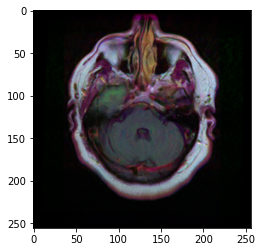

In [7]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

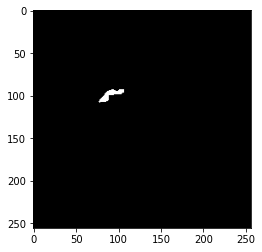

In [8]:
plt.imshow(cv2.imread(brain_df.mask_path[623]))

In [9]:
# Looking at range of pixels
cv2.imread(brain_df.image_path[623]).max(), cv2.imread(brain_df.image_path[623]).min()

(253, 0)

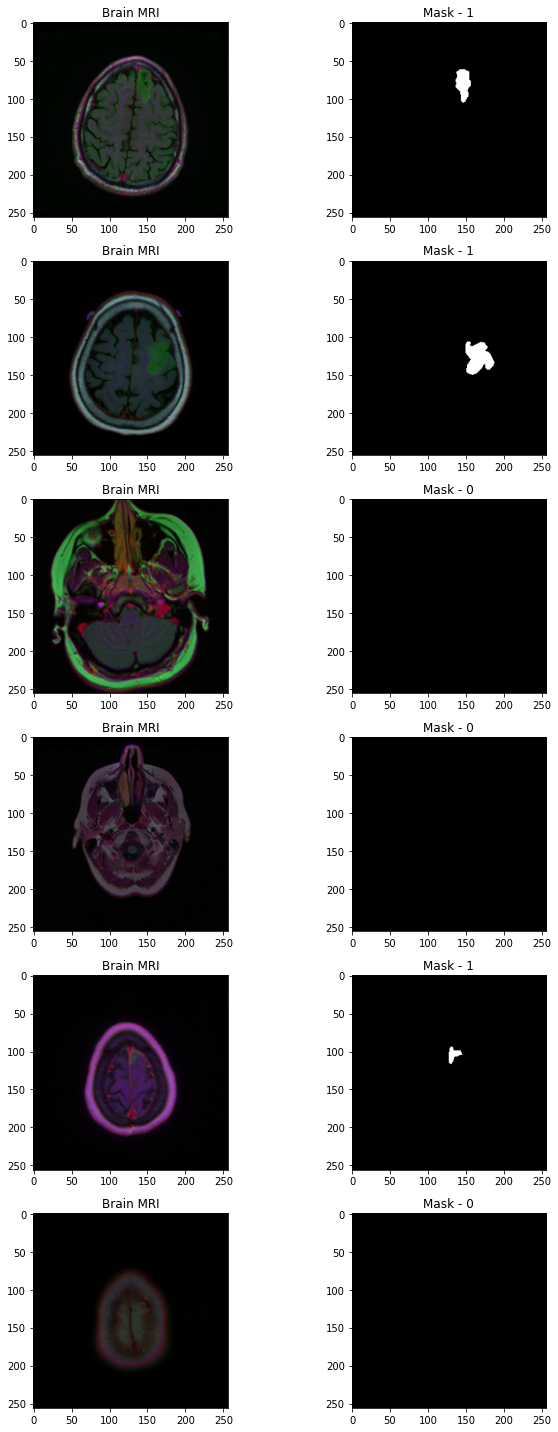

In [12]:
# Visualize the images (MRI and Mask) in the dataset separately
import random
fig, axs = plt.subplots(6,2, figsize=(10, 20))
count = 0
for x in range(6):
    i = random.randint(0, len(brain_df))
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(cv2.imread(brain_df.image_path[i]))
    axs[count][1].title.set_text('Mask - '+str(brain_df['mask'][i])) # If there is any tumour.
    axs[count][1].imshow(cv2.imread(brain_df.mask_path[i]))
    count +=1
fig.tight_layout()

In [17]:
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [19]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [21]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(brain_df_train, test_size=0.15)

In [22]:
# data generator which scales data from 0 to 1 and makes validation split of 0.15
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.15)

In [23]:
train_generator = datagen.flow_from_dataframe(
    dataframe = train, directory='./', x_col='image_path', y_col='mask', subset='training', batch_size=16, shuffle=True, class_mod='categorical', target_size=(256, 256)
)

Found 2839 validated image filenames belonging to 2 classes.


In [26]:
valid_generator = datagen.flow_from_dataframe(
    dataframe = train, directory='./', x_col='image_path', y_col='mask', subset='validation', batch_size=16, shuffle=True, class_mod='categorical', target_size=(256, 256)
)

Found 500 validated image filenames belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255.)

In [27]:
test_generator = datagen.flow_from_dataframe(
    dataframe = test, directory='./', x_col='image_path', y_col='mask', batch_size=16, shuffle=False, class_mod='categorical', target_size=(256, 256)
)

Found 590 validated image filenames belonging to 2 classes.


In [28]:
# Get ResNet50 base model
basemodel = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))
basemodel.summary()

94773248/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________

In [29]:
for layer in basemodel.layers:
    layers.trainable = False

In [31]:
# Add classification head to base model
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name='Flatten')(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation='softmax')(headmodel)

model = Model(inputs=basemodel.input, outputs=headmodel)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [33]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
checkpointer = ModelCheckpoint(filepath='classifier-resnet-weights.hdf5', verbose=1, save_best_only=True)
history = model.fit(
    train_generator, steps_per_epoch=train_generator.n // 16, epochs=1, validation_data=valid_generator, validation_steps=valid_generator.n //16,
    callbacks=[checkpointer, earlystopping]
)

177/177 [==============================] - ETA: 0s - loss: 0.7090 - accuracy: 0.7216
Epoch 00001: val_loss improved from inf to 3.94619, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 417s 2s/step - loss: 0.7090 - accuracy: 0.7216 - val_loss: 3.9462 - val_accuracy: 0.6915


In [35]:
# save model architecture to json file for future use.
model_json =  model.to_json()
with open('classifier-resnet-model.json', 'w') as json_file:
    json_file.write(model_json)

In [37]:
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel = json_file.read()
    
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

test_predict = model.predict(test_generator, steps=test_generator.n //16, verbose=1)

36/36 [==============================] - 14s 385ms/step


In [38]:
test_predict.shape

(576, 2)

In [39]:
test_predict

array([[9.9111360e-01, 8.8863866e-03],
       [1.0000000e+00, 4.5648694e-09],
       [1.0000000e+00, 4.0188284e-09],
       ...,
       [9.9996746e-01, 3.2564403e-05],
       [1.0000000e+00, 8.7476179e-11],
       [1.0037316e-12, 1.0000000e+00]], dtype=float32)

In [40]:
# obtain predicted class from model prediction
predict = []

for i in test_predict:
    predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [41]:
predict

array(['0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0',
       '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0',
       '0', '0', '1', '0', '0', '0', '1', '1', '0', '0', '1', '0', '1',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1',
       '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1',
       '0', '1', '0', '1', '0', '0', '1', '1', '0', '0', '1', '1', '1',
       '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0',
       '0', '1', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0',
       '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '0',
       '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0',
       '0', '1', '0', '1', '0', '0', '1', '0', '1', '0', '1', '0', '0',
       '1', '1', '1', '1', '1', '1', '0', '1', '0', '0', '0', '0', '0',
       '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1

In [42]:
original = np.asarray(test['mask'][:len(predict)])
len(original)

576

In [43]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(original, predict)
accuracy

0.9861111111111112

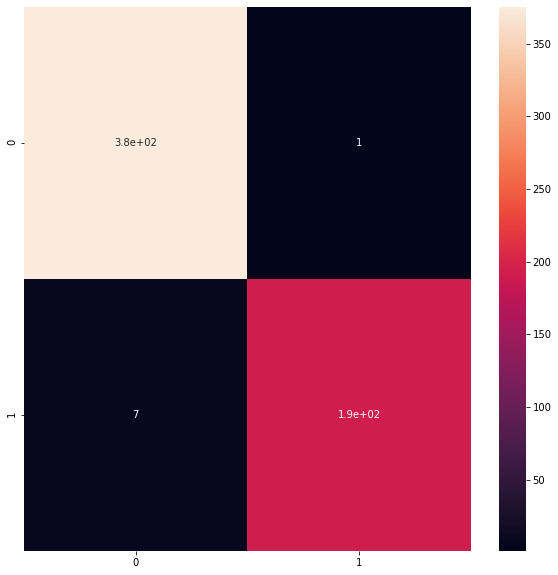

In [45]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True)


In [46]:
from sklearn.metrics import classification_report
report =classification_report(original, predict, labels=[0,1])
print(report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       376
           1       0.99      0.96      0.98       200

   micro avg       0.99      0.99      0.99       576
   macro avg       0.99      0.98      0.98       576
weighted avg       0.99      0.99      0.99       576



/usr/local/lib64/python3.6/site-packages/numpy/lib/arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [50]:
# Build segmentation model to localize Tumor
brain_df_mask = brain_df[brain_df['mask']==1]
brain_df_mask.shape

(1373, 4)

In [51]:
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.15)

In [53]:
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask = list(X_val.mask_path)

In [54]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import DataGenerator

training_generator = DataGenerator(train_ids, train_mask)
validation_generator = DataGenerator(val_ids, val_mask)

In [59]:
def resblock(X, f):
    X_copy = X
    X = Conv2D(f, kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    X_copy = Conv2D(f, kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    
    X = Add()([X, X_copy])
    X = Activation('relu')(X)
    
    return X

In [56]:
def upsample_concat(x, skip):
    x = UpSampling2D((2,2))(x)
    merge = Concatenate()([x, skip])
    return merge

In [63]:
input_shape = (256, 256, 3)
X_input = Input(input_shape)

conv1_in = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

conv5_in = resblock(pool_4, 256)

up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

output = Conv2D(1, (1,1), padding='same', activation='sigmoid')(up_4)
model_seg = Model(inputs = X_input, outputs = output)

In [64]:
model_seg.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 256, 256, 16) 448         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_56 (BatchNo (None, 256, 256, 16) 64          conv2d_56[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_14 (MaxPooling2D) (None, 128, 128, 16) 0           batch_normalization_56[0][0]     
____________________________________________________________________________________________

In [65]:
# Custom Loss functions

from utilities import focal_tversky, tversky_loss, tversky

adam = tf.keras.optimizers.Adam(lr=0.05, epsilon=0.1)
model_seg.compile(optimizer=adam, loss=focal_tversky, metrics=[tversky])
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save best model with lower validation loss
checkpointer = ModelCheckpoint(filepath='ResUNet-weights.hdf5', verbose=1, save_best_only=True)

In [66]:
history = model_seg.fit(training_generator, epochs=1, validation_data=validation_generator, callbacks=[checkpointer, earlystopping])

72/72 [==============================] - ETA: 0s - loss: 0.8415 - tversky: 0.2046
Epoch 00001: val_loss improved from inf to 0.74554, saving model to ResUNet-weights.hdf5
72/72 [==============================] - 152s 2s/step - loss: 0.8415 - tversky: 0.2046 - val_loss: 0.7455 - val_tversky: 0.3240


In [67]:
model_json = model_seg.to_json()
with open('ResUNet-model.hdf5', 'w') as json_file:
    json_file.write(model_json)

In [68]:
with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel = json_file.read()
    
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr=0.05, epsilon=0.1)
model_seg.compile(optimizer=adam, loss=focal_tversky, metrics=[tversky])

In [69]:
from utilities import prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

In [71]:
df_pred = pd.DataFrame({'image_path': image_id,  'predicted_mask': mask, 'has_mask': has_mask})
df_pred.head(3)

,image_path,predicted_mask,has_mask
0,TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_33...,No mask,0
1,TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_2.tif,No mask,0
2,TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_39...,No mask,0


In [80]:
df_pred = test.merge(df_pred, on='image_path')
df_pred.head(4)

,image_path,mask_path,mask,predicted_mask,has_mask
0,TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_33...,TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_33...,0,No mask,0
1,TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_2.tif,TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_2_...,0,No mask,0
2,TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_39...,TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_39...,0,No mask,0
3,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6_...,1,"[[[[8.02067e-07], [3.595287e-06], [1.0548609e-...",1


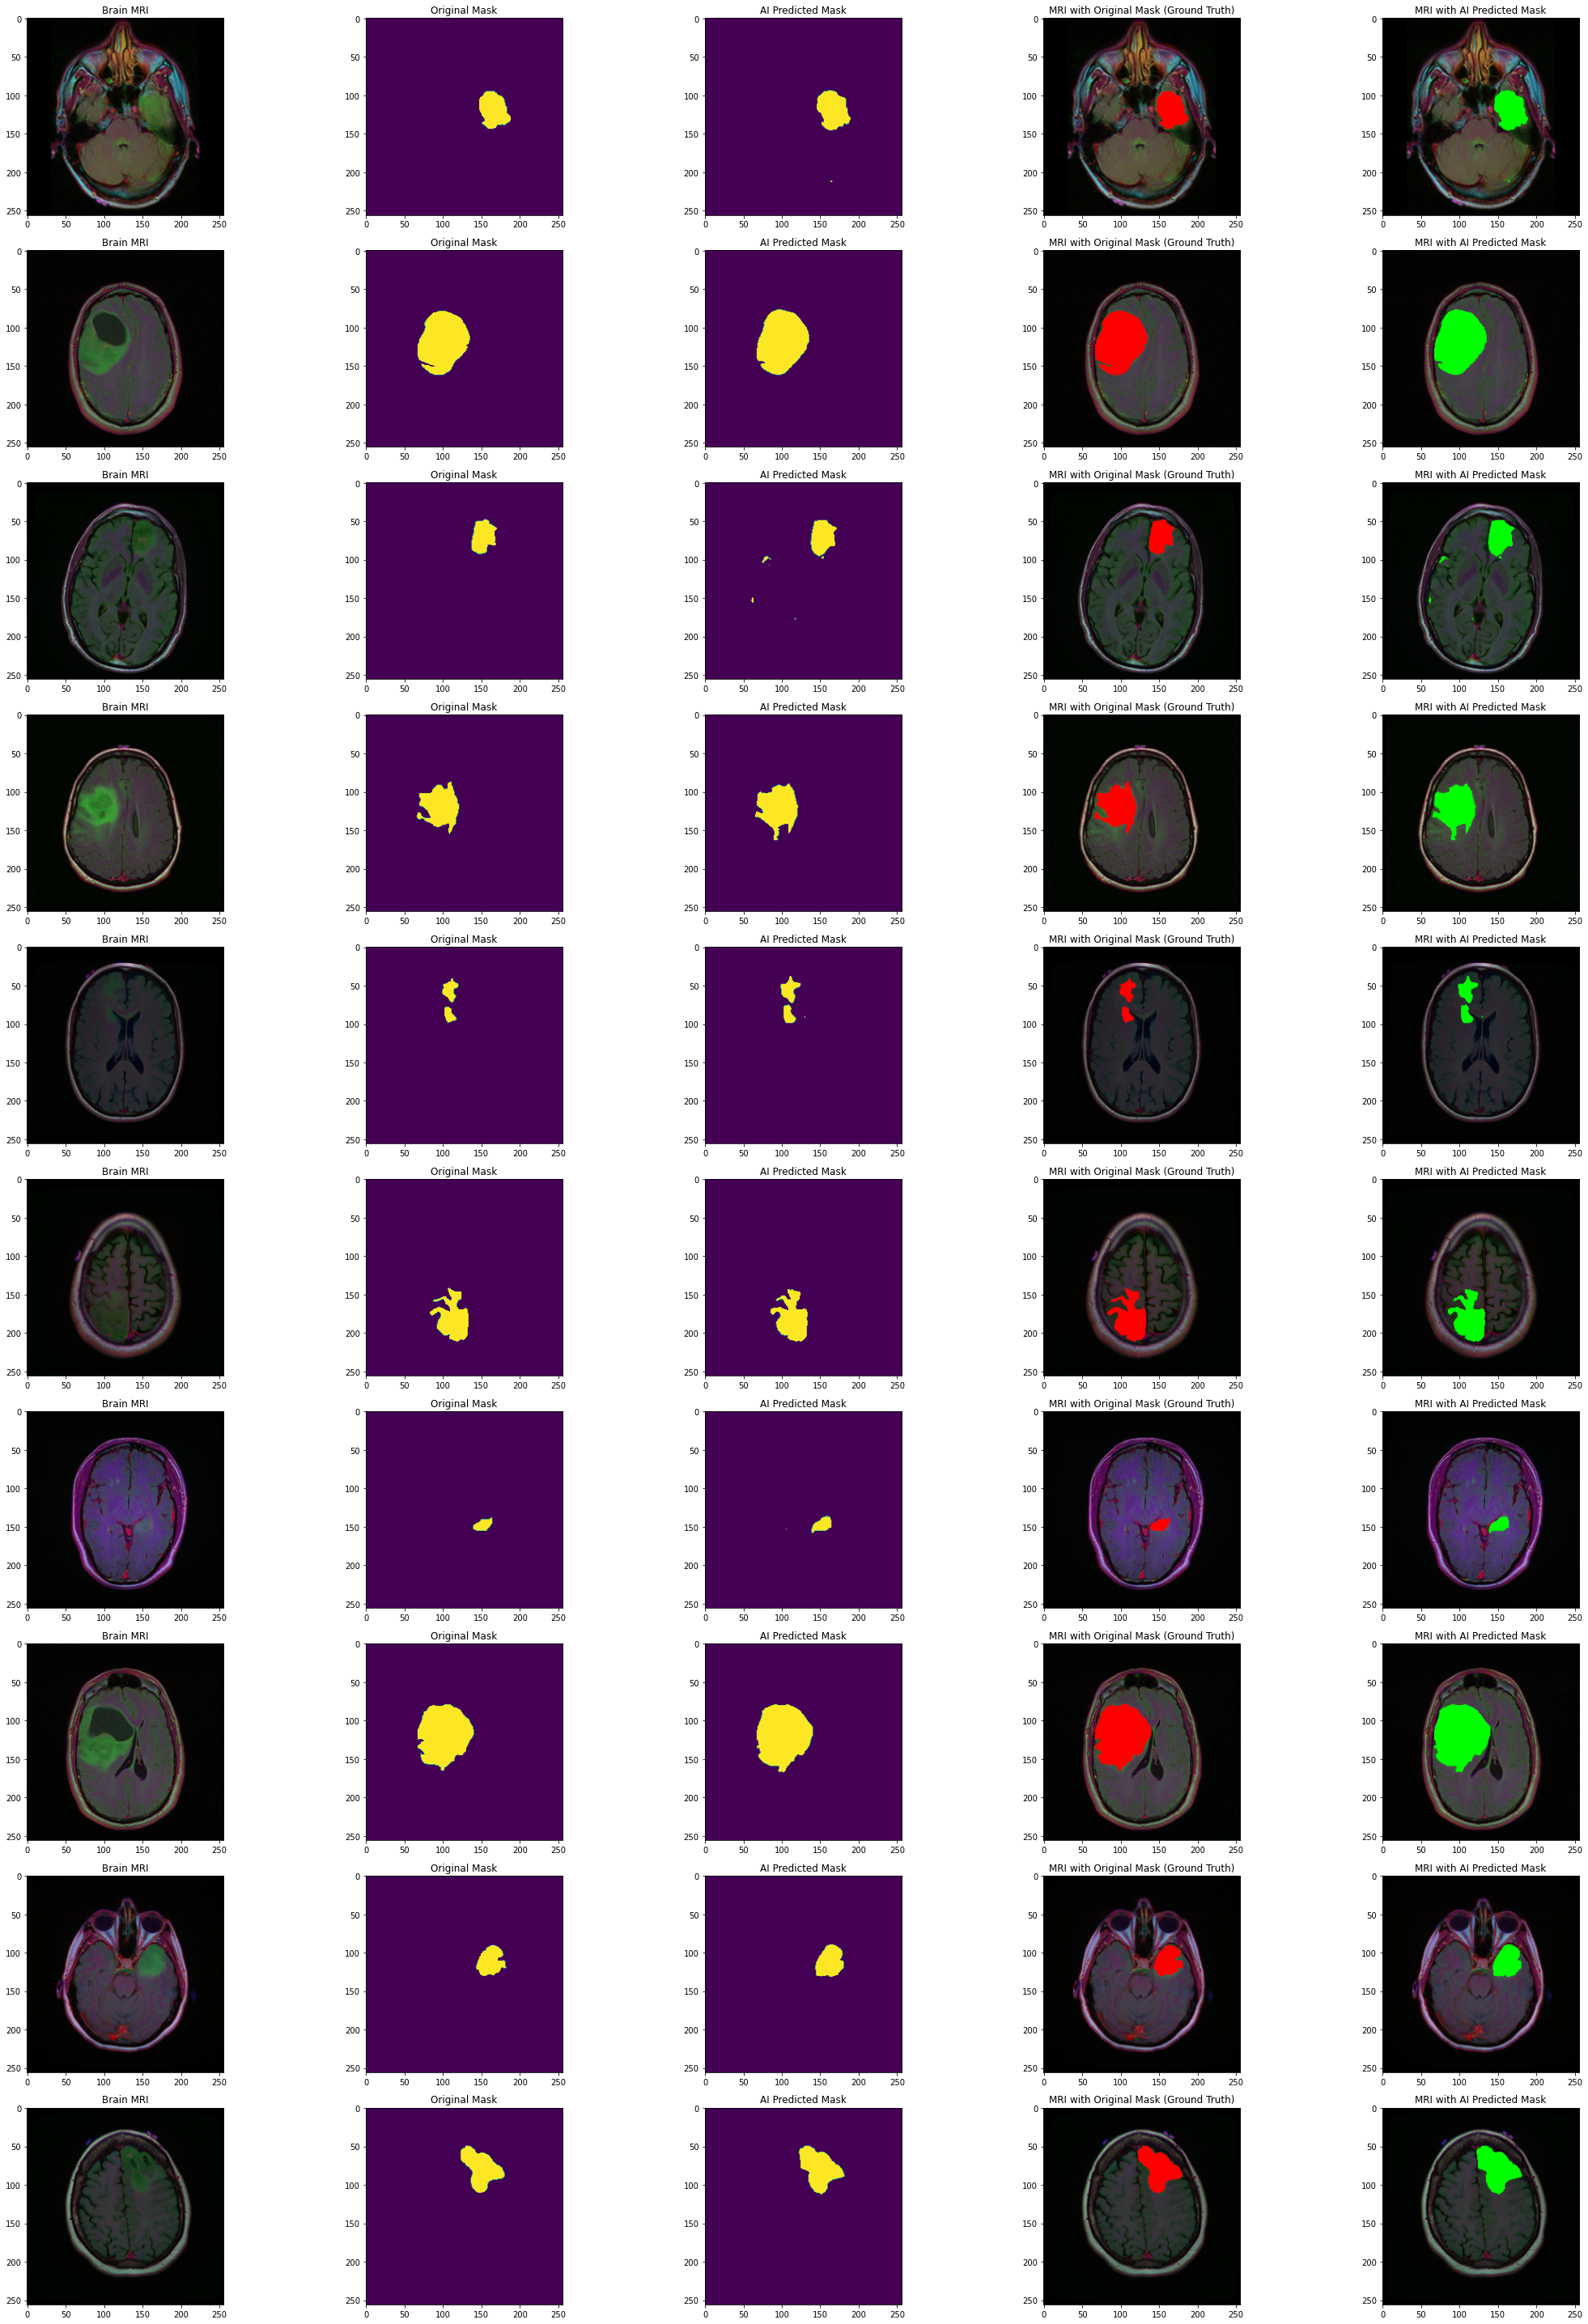

In [81]:
count = 0
fig, axs = plt.subplots(10, 5, figsize=(30, 40))

for i in range(len(df_pred)):
    if df_pred['has_mask'][i] == 1 and count < 10:
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].title.set_text('Brain MRI')
        axs[count][0].imshow(img)
        
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].title.set_text('Original Mask')
        axs[count][1].imshow(mask)
        
        predicted_mask = np.asarray(df_pred.predicted_mask[i][0].squeeze().round())
        axs[count][2].title.set_text('AI Predicted Mask')
        axs[count][2].imshow(predicted_mask)
        
        img[mask==255] = (255, 0, 0)
        axs[count][3].title.set_text('MRI with Original Mask (Ground Truth)')
        axs[count][3].imshow(img)
        
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[predicted_mask==1] = (0, 255, 0)
        axs[count][4].title.set_text('MRI with AI Predicted Mask')
        axs[count][4].imshow(img_)
        count += 1
        
fig.tight_layout()